In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchviz import make_dot
import torchvision.models
from torchsummary import summary

from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(
    root = '.',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

100%|██████████| 26421880/26421880 [00:00<00:00, 116245529.63it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 7976988.37it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 60922193.96it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22848970.36it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [ ]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
test_dataset = torchvision.datasets.FashionMNIST(
    root = '.',
    train = False,
    transform = transforms.ToTensor(),
    download = True
)

In [ ]:
# Number of Classes
k = len(set(train_dataset.targets.numpy()))
print(f'Number of classes: {k}')

Number of classes: 10


In [ ]:
# Defining the model

class CNN(nn.Module):
    def __init__(self, k):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 2),
            nn.ReLU(),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, k)
        )

    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [ ]:
# Instantiating the model
model = CNN(k)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
# Defining Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Creating a data loader
# This is usefull because it will automatically generate batches in the training loop and it takes care of shuffling

batchsize = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batchsize, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batchsize, shuffle = False)

In [ ]:
# Creating a function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # Move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameters gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get the train loss and test loss
        train_loss = np.mean(train_loss) # This is a little misleading

        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())

        test_loss = np.mean(test_loss)

        # Saving the losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')

    return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs = 20)

Epoch 1/20, Train Loss: 0.6580, Test Loss: 0.4822, Duration: 0:00:16.350444
Epoch 2/20, Train Loss: 0.4237, Test Loss: 0.4158, Duration: 0:00:09.368639
Epoch 3/20, Train Loss: 0.3601, Test Loss: 0.3695, Duration: 0:00:09.707417
Epoch 4/20, Train Loss: 0.3265, Test Loss: 0.3467, Duration: 0:00:08.758994
Epoch 5/20, Train Loss: 0.2991, Test Loss: 0.3438, Duration: 0:00:09.464044
Epoch 6/20, Train Loss: 0.2737, Test Loss: 0.3118, Duration: 0:00:10.050445
Epoch 7/20, Train Loss: 0.2563, Test Loss: 0.3304, Duration: 0:00:09.184951
Epoch 8/20, Train Loss: 0.2387, Test Loss: 0.3058, Duration: 0:00:08.927080
Epoch 9/20, Train Loss: 0.2271, Test Loss: 0.3007, Duration: 0:00:09.640261
Epoch 10/20, Train Loss: 0.2095, Test Loss: 0.3090, Duration: 0:00:09.277873
Epoch 11/20, Train Loss: 0.2013, Test Loss: 0.2998, Duration: 0:00:08.808623
Epoch 12/20, Train Loss: 0.1846, Test Loss: 0.3100, Duration: 0:00:09.673459
Epoch 13/20, Train Loss: 0.1729, Test Loss: 0.3069, Duration: 0:00:09.373439
Epoch 14

In [ ]:
# torch.onnx.export(model, )

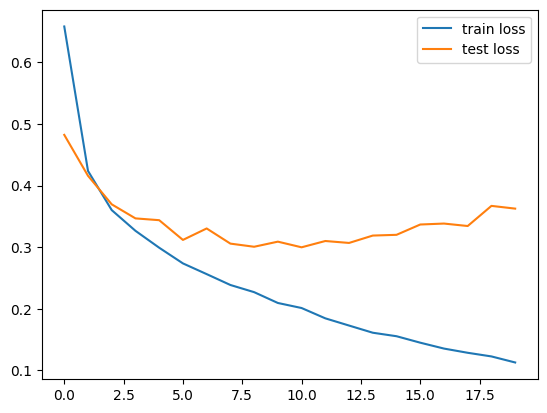

In [ ]:
# Plotting the train and loss as weall as the test and loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [ ]:
# Getting the Accuracy

n_correct = 0
n_total = 0

for inputs, targets in train_loader:
    # Move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Getting teh prediction
    # torch.max returns both the max and the argmax
    _, predictions = torch.max(outputs, 1)

    # Updating the counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0
n_total = 0

for inputs, targets in train_loader:
    # Move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Getting teh prediction
    # torch.max returns both the max and the argmax
    _, predictions = torch.max(outputs, 1)

    # Updating the counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

Train Accuracy: 0.9623, Test Accuracy: 0.9633


In [ ]:
from prompt_toolkit.layout.containers import HorizontalAlign
# Creating a Confusion Matrix
def plot_confucion_matrix(cm, classes, normalize = False, title = 'Confucion Matrix', cmap = plt.cm.Blues):
    '''
    This function plrint and plots teh confusion matrix.
    Normalization can be applied by setting the parameter `normalize = True`
    '''

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')

    else:
        print('Confusion Matrix without normalization')

    print(cm)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    tresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > tresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Confusion Matrix without normalization
[[864   3  28  19   3   1  75   0   7   0]
 [  4 974   2  14   4   0   1   0   1   0]
 [ 17   0 877  17  46   0  39   0   4   0]
 [ 19   3  16 906  31   1  22   0   0   2]
 [  2   0  65  22 850   0  56   0   5   0]
 [  1   0   0   2   1 972   0  16   1   7]
 [124   1  79  34 104   0 647   0  11   0]
 [  0   0   0   0   0  11   0 955   0  34]
 [  3   0   4   7   6   2   4   4 970   0]
 [  1   0   0   0   0   5   0  30   0 964]]


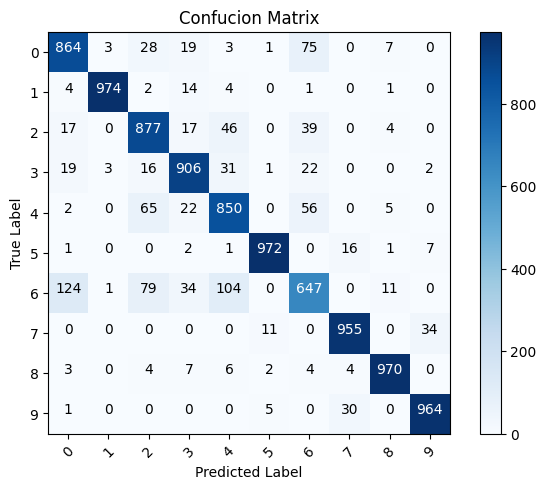

In [ ]:
# Getting all predictions into an array and plotting the confusion matrix
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    # Move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Getting teh prediction
    _, predictions = torch.max(outputs, 1)

    # Updating p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confucion_matrix(cm, list(range(10)))

In [ ]:
# Creating a label map since the classes are listed as integers and thus makes the predictions hard to read
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot
'''.split('\n')

Text(0.5, 1.0, 'True Label: Sandal Predicted: Sandal')

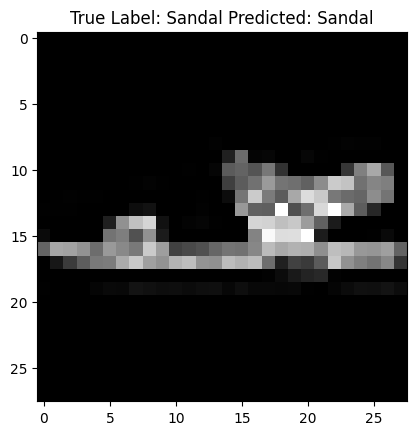

In [ ]:
# Showing some classified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test == y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28, 28), cmap = 'gray')
plt.title('True Label: %s Predicted: %s' % (labels[y_test[i]], labels[p_test[i]]))

Text(0.5, 1.0, 'True Label: T-shirt/top Predicted: Pullover')

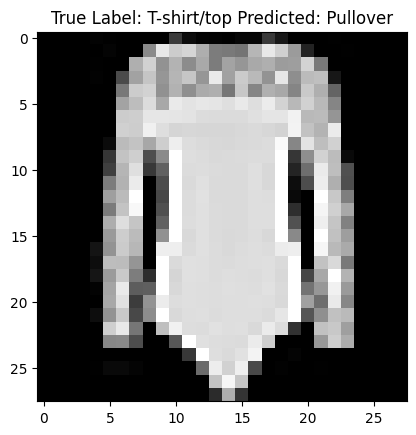

In [ ]:
# Showing some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28, 28), cmap = 'gray')
plt.title('True Label: %s Predicted: %s' % (labels[y_test[i]], labels[p_test[i]]))

In [ ]:
torch.save(model, "mnist.h5")